In [1]:
import sys
import re
# sys.path.append('../')
import time
import collections
import argparse
import os
import shutil
import json
import datetime

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Possible Improvements

- Figure out transform for inception net
    * 
- Examine Loss function
- Visualize attention maps from different layers

In [2]:
%load_ext autoreload
%autoreload 2
# from my_optim import get_optimizer, adject_lr
import exper.my_optim as my_optim
from models import *
from utils import AverageMeter
from utils import Metrics
from utils.save_atten import SAVE_ATTEN
from utils.LoadDataAiSky import data_loader
from utils.Restore import restore

In [8]:
class dummy_val_args:
    def __init__(self):
        self.arch = "inception3_spg"
        self.batch_size = 2
        self.lr = 0.001
        self.num_classes = 2
        self.num_gpu = 1
        self.threshold = 0.6
        self.snapshot_dir = "./snapshots/pretrain_imagenet/"
        self.restore_from = "AiSky_epoch_3_glo_step_5704.pth.tar"
        self.resume = "True"
        self.tencrop = "False"

class dummy_tr_args:
    def __init__(self):
        self.arch = "inception3_spg"
        self.batch_size = 16
        self.lr = 0.001
        self.epoch = 25
        self.num_gpu = 1
        self.num_classes = 2
        self.snapshot_dir = "./snapshots/pretrain_imagenet/"
        self.restore_from = "imagenet_epoch_2_glo_step_128118.pth.tar"
        self.global_counter = 0
        self.current_epoch = 0
        self.threshold = 0.6
        self.decay_points = "none"
        self.onehot = 'False'
        self.disp_interval = 100
        self.dataset = "AiSky"
        self.resume = "True"

        

val_args = dummy_val_args()
args = dummy_tr_args()
        

In [4]:
def evaluate(args, model, loader):
    losses = AverageMeter()
    top1 = AverageMeter()
    losses.reset()
    top1.reset()

    model.eval()
    for idx, dat in enumerate(loader):
        img, label = dat
        if len(img) == 1:
            continue
        label = torch.FloatTensor([t["label"] for t in label])[:, None]

        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])
        
        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
#         if args.tencrop == 'True':
#             logits0 = logits0.view(bs, ncrops, -1).mean(1)

        # Calculate classification results
#         if args.onehot == 'True':
#             val_mAP, prob, gt = cal_mAP(logits0, label_var, prob, gt)
            # print val_mAP
#         else:
        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

    return losses.avg, top1.avg

In [5]:
def get_model(args):
    model = eval(args.arch).model(pretrained=False,
                                  num_classes=1000,
                                  threshold=args.threshold,
                                  args=args)
    model.cuda()
    model = torch.nn.DataParallel(model, range(args.num_gpu))

    optimizer = my_optim.get_finetune_optimizer(args, model)

    if args.resume == 'True':
        restore(args, model, optimizer, including_opt=False)
    return  model, optimizer

def save_checkpoint(args, state, is_best, filename='checkpoint.pth.tar'):
    savepath = os.path.join(args.snapshot_dir, filename)
    torch.save(state, savepath)
    if is_best:
        shutil.copyfile(savepath, os.path.join(args.snapshot_dir, 'model_best.pth.tar'))

In [6]:

def train(args):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model, optimizer= get_model(args)
    model.train()
    train_loader, val_loader = data_loader(args)

    with open(os.path.join(args.snapshot_dir, 'train_record.csv'), 'a') as fw:
        config = json.dumps(vars(args), indent=4, separators=(',', ':'))
        fw.write(config)
        fw.write('#epoch,loss,pred@1,pred@5\n')


    total_epoch = args.epoch
    global_counter = 0 #args.global_counter
    current_epoch = 0 #args.current_epoch
    end = time.time()
    max_iter = total_epoch*len(train_loader)
    print('Max iter:', max_iter)
    while current_epoch < total_epoch:
        model.train()
        losses.reset()
        top1.reset()
        top5.reset()
        batch_time.reset()
        res = my_optim.reduce_lr(args, optimizer, current_epoch)

        if res:
            for g in optimizer.param_groups:
                out_str = 'Epoch:%d, %f\n'%(current_epoch, g['lr'])
                fw.write(out_str)

        steps_per_epoch = len(train_loader)
        for idx, dat in enumerate(train_loader):
            #img_path , img, label = dat
            img, label = dat
            label = torch.FloatTensor([t["label"] for t in label])[:, None]
            global_counter += 1
            img, label = img.cuda(), label.cuda()
            img_var, label_var = Variable(img), Variable(label)

            logits = model(img_var,  label_var)
            loss_val, _ = model.module.get_loss(logits, label_var)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if not args.onehot == 'True':
                logits1 = torch.squeeze(logits[0])
                prec1_1 = Metrics.accuracy(logits1.data, label.long(), topk=(1,))
                top1.update(prec1_1[0].item(), img.size()[0])
            losses.update(loss_val.data, img.size()[0])
            batch_time.update(time.time() - end)

            end = time.time()

            if global_counter % args.disp_interval == 0:
                # Calculate ETA
                eta_seconds = ((total_epoch - current_epoch)*steps_per_epoch + (steps_per_epoch - idx))*batch_time.avg
                eta_str = "{}".format(datetime.timedelta(seconds=int(eta_seconds)))
                eta_seconds_epoch = steps_per_epoch*batch_time.avg
                eta_str_epoch = "{}".format(datetime.timedelta(seconds=int(eta_seconds_epoch)))
                print('Epoch: [{0}][{1}/{2}] '
                      'AvgBatchTime {batch_time.avg:.3f} '
                      'ETA {eta_str}({eta_str_epoch}) '
                      'Loss {loss.val:.4f} ({loss.avg:.4f}) '
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                    current_epoch, global_counter%len(train_loader), len(train_loader), batch_time=batch_time,
                    eta_str=eta_str, eta_str_epoch = eta_str_epoch, loss=losses, top1=top1))

        print("=================================")
        print("Evaluation on val-set:")
        val_loss, val_prec_1 = evaluate(args, model, val_loader)
        print("\tEpoch %i: Val Loss: %.3f\tVal Prec@1: %.3f" % (current_epoch, val_loss, val_prec_1))
        print("=================================")
        print("")
        model.train()
                
        if current_epoch % 1 == 0:
            save_checkpoint(args,
                            {
                                'epoch': current_epoch,
                                'arch': 'resnet',
                                'global_counter': global_counter,
                                'state_dict':model.state_dict(),
                                'optimizer':optimizer.state_dict()
                            }, is_best=False,
                            filename='%s_epoch_%d_glo_step_%d.pth.tar'
                                     %(args.dataset, current_epoch,global_counter))

        with open(os.path.join(args.snapshot_dir, 'train_record.csv'), 'a') as fw:
            fw.write('%d,%.4f,%.3f,%.4f,%.3f\n'%(current_epoch, losses.avg, top1.avg, val_loss, val_prec_1))

        current_epoch += 1


In [7]:
train(args)

/projectnb/saenkog/shawnlin/object-tracking/SPG/models/google/inception3_spg.py:137: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


=> loading checkpoint './snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar'
=> loaded checkpoint './snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar' (epoch 2)
=> loaded checkpoint './snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar'
Max iter: 35650


/usr4/cs591/shawnlin/.local/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr4/cs591/shawnlin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: [0][100/1426] AvgBatchTime 0.190 ETA 1:57:10(0:04:31) Loss 0.7688 (1.2041) Prec@1 87.500 (81.375)
Epoch: [0][200/1426] AvgBatchTime 0.189 ETA 1:56:10(0:04:29) Loss 0.3199 (0.8764) Prec@1 93.750 (84.938)
Epoch: [0][300/1426] AvgBatchTime 0.190 ETA 1:56:26(0:04:30) Loss 0.8018 (0.7422) Prec@1 81.250 (86.333)
Epoch: [0][400/1426] AvgBatchTime 0.189 ETA 1:55:49(0:04:30) Loss 0.3941 (0.6663) Prec@1 87.500 (87.375)
Epoch: [0][500/1426] AvgBatchTime 0.189 ETA 1:55:20(0:04:29) Loss 0.5134 (0.6153) Prec@1 81.250 (88.112)
Epoch: [0][600/1426] AvgBatchTime 0.189 ETA 1:54:51(0:04:29) Loss 0.2058 (0.5764) Prec@1 100.000 (88.750)
Epoch: [0][700/1426] AvgBatchTime 0.189 ETA 1:54:24(0:04:29) Loss 0.2071 (0.5476) Prec@1 100.000 (89.152)
Epoch: [0][800/1426] AvgBatchTime 0.189 ETA 1:54:04(0:04:29) Loss 0.2109 (0.5280) Prec@1 100.000 (89.477)
Epoch: [0][900/1426] AvgBatchTime 0.189 ETA 1:53:41(0:04:28) Loss 0.4046 (0.5096) Prec@1 87.500 (89.715)
Epoch: [0][1000/1426] AvgBatchTime 0.190 ETA 1:54:00

Epoch: [5][70/1426] AvgBatchTime 0.595 ETA 4:56:02(0:14:07) Loss 0.2504 (0.1388) Prec@1 93.750 (99.107)
Epoch: [5][170/1426] AvgBatchTime 0.358 ETA 2:57:35(0:08:30) Loss 0.1192 (0.1555) Prec@1 100.000 (98.676)
Epoch: [5][270/1426] AvgBatchTime 0.295 ETA 2:26:06(0:07:01) Loss 0.1133 (0.1494) Prec@1 100.000 (98.843)
Epoch: [5][370/1426] AvgBatchTime 0.267 ETA 2:11:28(0:06:20) Loss 0.3566 (0.1497) Prec@1 93.750 (98.851)
Epoch: [5][470/1426] AvgBatchTime 0.250 ETA 2:02:56(0:05:56) Loss 0.1565 (0.1513) Prec@1 100.000 (98.763)
Epoch: [5][570/1426] AvgBatchTime 0.240 ETA 1:57:17(0:05:41) Loss 0.1741 (0.1520) Prec@1 93.750 (98.717)
Epoch: [5][670/1426] AvgBatchTime 0.232 ETA 1:53:23(0:05:31) Loss 0.2117 (0.1526) Prec@1 93.750 (98.657)
Epoch: [5][770/1426] AvgBatchTime 0.227 ETA 1:50:27(0:05:23) Loss 0.1105 (0.1524) Prec@1 100.000 (98.677)
Epoch: [5][870/1426] AvgBatchTime 0.223 ETA 1:48:07(0:05:18) Loss 0.1069 (0.1508) Prec@1 100.000 (98.707)
Epoch: [5][970/1426] AvgBatchTime 0.220 ETA 1:46:13

KeyboardInterrupt: 

In [43]:
def val(args, model=None, current_epoch=0):
    top1 = AverageMeter()
    top5 = AverageMeter()
    losses = AverageMeter()
    top1.reset()
    top5.reset()
    losses.reset()

    if model is None:
        model, _ = get_model(args)
    model.eval()
    train_loader, val_loader = data_loader(args, test_path=True)

    save_atten = SAVE_ATTEN(save_dir='../save_bins/')

    global_counter = 0
    prob = None
    gt = None
    for idx, dat  in enumerate(val_loader):
        img, label = dat
        if len(img) == 1:
            continue
        if idx > 100:
            break
        label = torch.FloatTensor([t["label"] for t in label])[:, None]

        global_counter += 1
        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])

        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
        if args.tencrop == 'True':
            logits0 = logits0.view(bs, ncrops, -1).mean(1)

        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

        # model.module.save_erased_img(img_path)
        if idx < 50 and label[0] != 0:
            last_featmaps = model.module.get_localization_maps()
            np_last_featmaps = last_featmaps.cpu().data.numpy()
            np_last_featmaps_resize = cv2.resize(np_last_featmaps[0][1], (224, 224))
        
            print("heat", np_last_featmaps.shape, np_last_featmaps.max(), np_last_featmaps.min())
            
            plt.figure(figsize=(9, 27), dpi=80)
            plt.subplot(1,3,1)
            plt.title("Heatmap")
            plt.imshow(np_last_featmaps_resize)
            plt.subplot(1,3,2)
            img_cpu = img[0].cpu().permute(1,2,0)
            plt.title("Raw Image")
            plt.imshow(img_cpu)
            plt.subplot(1,3,3)
            seg_mask = (np_last_featmaps_resize >= 0.3).astype(np.float)
            plt.title("Image w/t SegMask")
            plt.imshow(img_cpu)
            plt.imshow(seg_mask, cmap="plasma", alpha=0.5)
            plt.show()

    print("Testing Loss: %.4f\tAcc: %.3f" % (losses.avg, top1.avg))

=> loading checkpoint './snapshots/pretrain_imagenet/AiSky_epoch_6_glo_step_9982.pth.tar'
=> loaded checkpoint './snapshots/pretrain_imagenet/AiSky_epoch_6_glo_step_9982.pth.tar' (epoch 6)
=> loaded checkpoint './snapshots/pretrain_imagenet/AiSky_epoch_6_glo_step_9982.pth.tar'
heat (2, 1000, 28, 28) 1.0 0.0


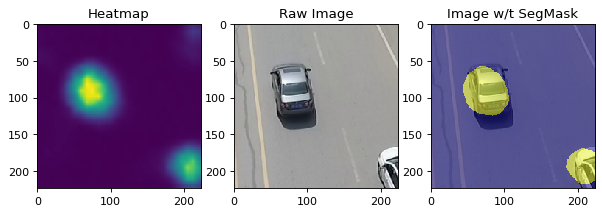

heat (2, 1000, 28, 28) 1.0 0.0


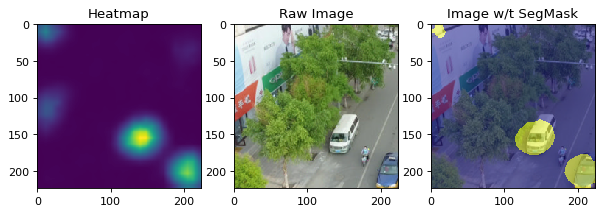

heat (2, 1000, 28, 28) 1.0 0.0


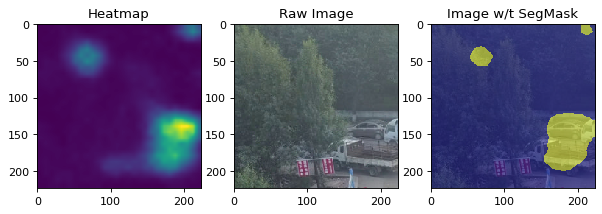

heat (2, 1000, 28, 28) 1.0 0.0


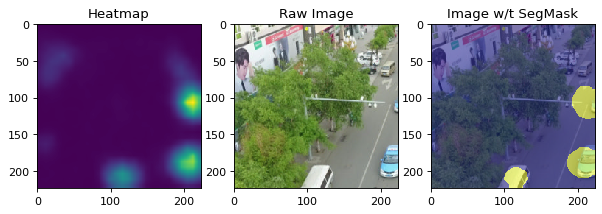

heat (2, 1000, 28, 28) 1.0 0.0


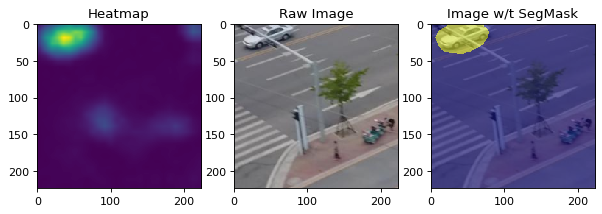

heat (2, 1000, 28, 28) 1.0 0.0


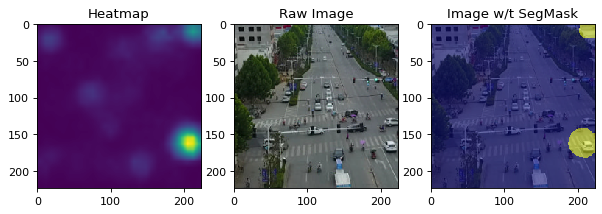

heat (2, 1000, 28, 28) 1.0 0.0


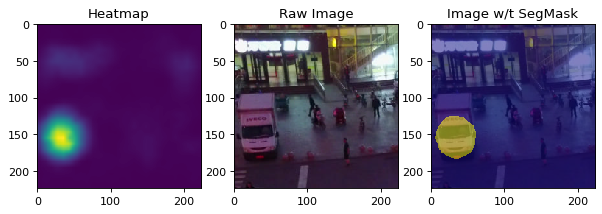

heat (2, 1000, 28, 28) 1.0 0.0


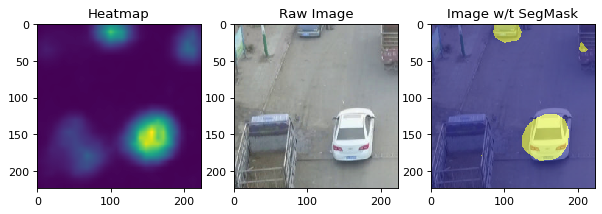

heat (2, 1000, 28, 28) 1.0 0.0


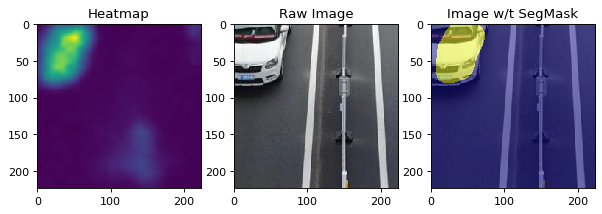

heat (2, 1000, 28, 28) 1.0 0.0


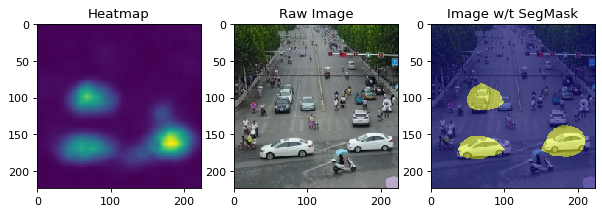

heat (2, 1000, 28, 28) 1.0 0.0


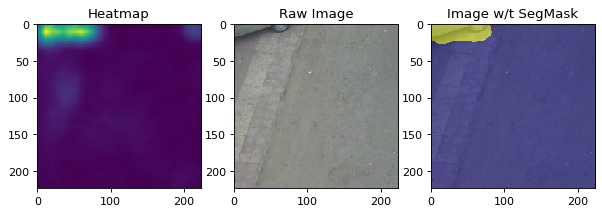

heat (2, 1000, 28, 28) 1.0 0.0


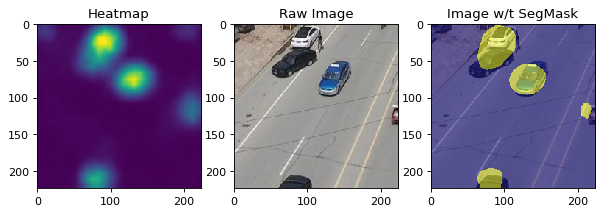

heat (2, 1000, 28, 28) 1.0 0.0


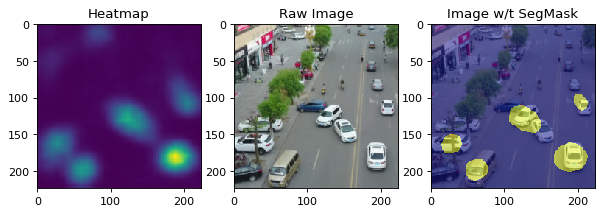

heat (2, 1000, 28, 28) 1.0 0.0


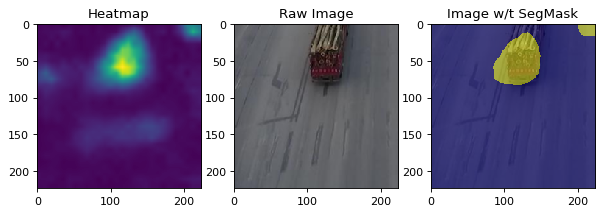

heat (2, 1000, 28, 28) 1.0 0.0


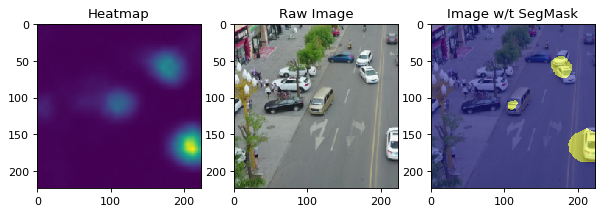

heat (2, 1000, 28, 28) 1.0 0.0


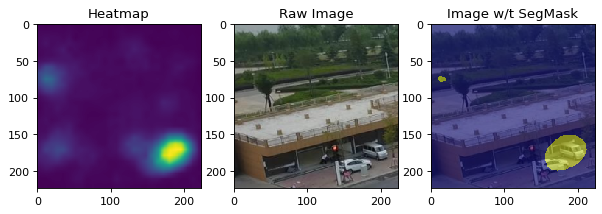

heat (2, 1000, 28, 28) 1.0 0.0


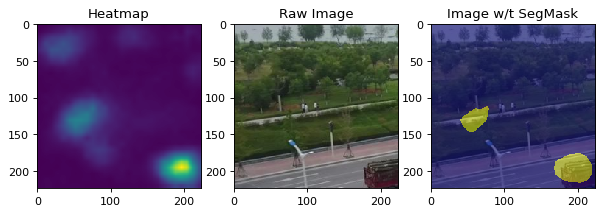

heat (2, 1000, 28, 28) 1.0 0.0


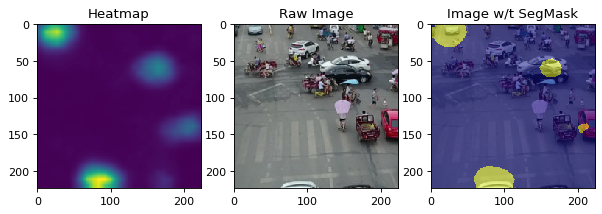

heat (2, 1000, 28, 28) 1.0 0.0


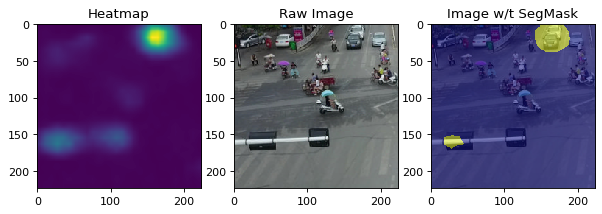

heat (2, 1000, 28, 28) 1.0 0.0


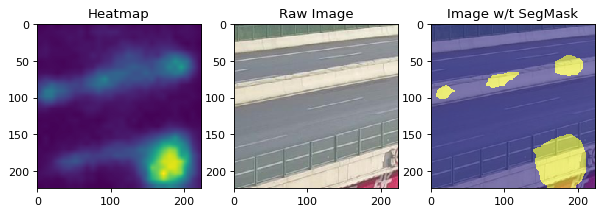

heat (2, 1000, 28, 28) 1.0 0.0


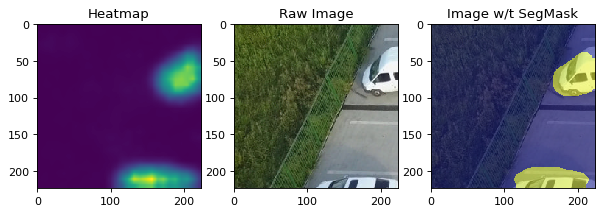

heat (2, 1000, 28, 28) 1.0 0.0


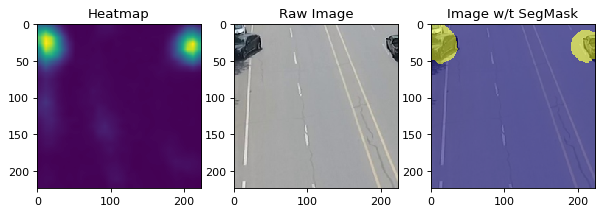

heat (2, 1000, 28, 28) 1.0 0.0


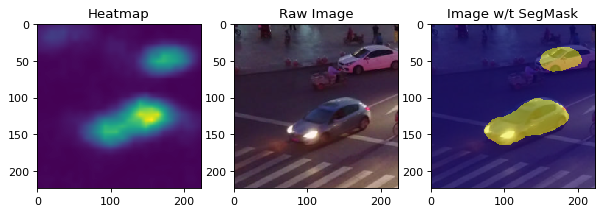

heat (2, 1000, 28, 28) 1.0 0.0


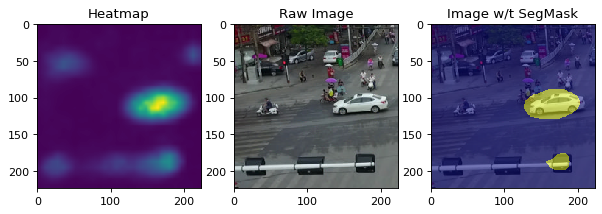

heat (2, 1000, 28, 28) 1.0 0.0


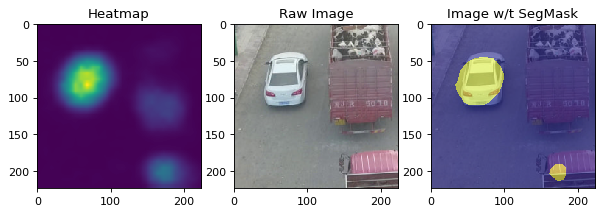

heat (2, 1000, 28, 28) 1.0 0.0


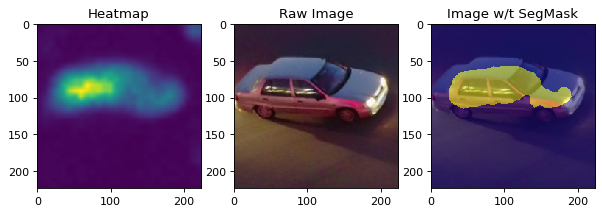

Testing Loss: 0.4809	Acc: 86.139


In [44]:
val(val_args)